In [1]:
import networkx as nx
import preprocessing as prep
import numpy as np
import pandas as pd
import numpy as np
import json
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from bb_binary import load_frame_container, Repository
from pandas import Series, DataFrame
import seaborn as sns
import igraph as ig
import sqlite3

In [2]:
%matplotlib inline

In [3]:
graph_files = os.listdir()
graph_files = [g for g in graph_files if g.endswith('.graphml')]

In [4]:
graph_files

['2016-07-21T15:00:00Z_1h_allCams-97_0.97conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-93_0.93conf_212dist_3ilen.graphml',
 '14hDay_0.99conf_212dist_3ilen.graphml',
 'TTT_0.95conf_212dist_3ilen.graphml',
 '3h_0.99conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-100_1.0conf_212dist_3ilen.graphml',
 '1h_0.99conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-94_0.94conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-99_0.99conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-90_0.9conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-96_0.96conf_212dist_3ilen.graphml',
 '1h_0.99conf_175dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-95_0.95conf_212dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-98_0.98conf_212dist_3ilen.graphml',
 '2h_0.99conf_175dist_3ilen.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-91_0.91conf_212dist_3ilen.graphml',
 'ttt.graphml',
 '2016-07-21T15:00:00Z_1h_allCams-92_0.92conf_212dis

# Network Analysis - Example: One hour Network
* Confidence 0.99, 212px radius, 3 frames as intractionlength.
* hour-Networks 21.07.2016
* cutoff 10
* gap size 2
* '2016-07-21T15:00:00Z_1h_allCams-99_0.99conf_212dist_3ilen.graphml'

In [5]:
# graph_list = []

# for eg in graph_files:
#     G = nx.read_graphml(eg)
#     date = eg.split("_")[0]
#     date_dt = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
#     date_ts = date_dt.timestamp()
#     graph_list.append((date_dt,G))

# G = graph_list[0][1]

In [5]:
G = nx.read_graphml('TTT_0.95conf_212dist_3ilen.graphml')

## Global Properties

### Nodes, Edges, average Degree and Density

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1024
Number of edges: 112144
Average degree: 219.0312


In [7]:
Series(G.degree()).mean()

219.03125

In [8]:
density = nx.density(G)
density

0.21410679374389052

### Degree distribution

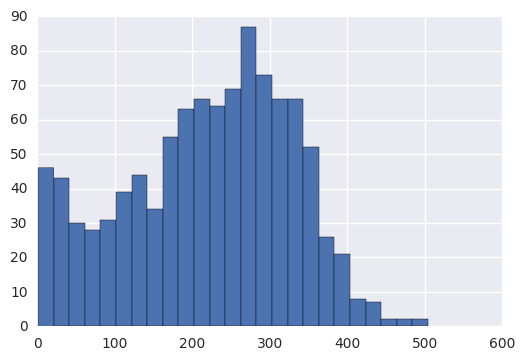

In [9]:
degrees = G.degree().values()
s = Series(list(degrees))
s.hist(bins=25)

In [10]:
s.describe()

count    1024.000000
mean      219.031250
std       108.043287
min         1.000000
25%       140.000000
50%       232.000000
75%       300.250000
max       504.000000
dtype: float64

### Edge weights distribution

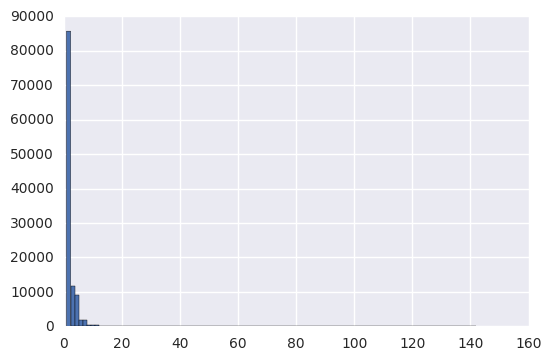

In [11]:
l = []

for e in G.edges():
    l.append(G.get_edge_data(e[0],e[1]).get("frequency"))
    # totalduration

edge_weights = Series(l)

fig, ax = plt.subplots()
#ax.set_yscale('log')
edge_weights.hist(bins=100)

In [12]:
edge_weights.median()

1.0

### Weighted Degree Distribution

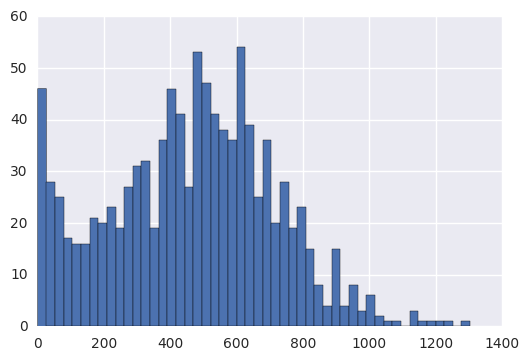

In [13]:
#degrees = G.degree(weight='frequency').values()
degrees = G.degree(weight='totalduration').values()
s = Series(list(degrees))
s.hist(bins=50)

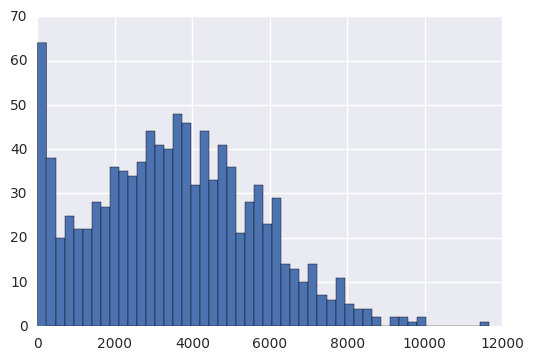

In [14]:
#degrees = G.degree(weight='frequency').values()
degrees = G.degree(weight='totalduration').values()
s = Series(list(degrees))
s.hist(bins=50)

### Number of components and size distribution

In [15]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 1


Counter({1024: 1})

In [16]:
# keepthe biggest Component
G = Gcc[0]

There is one big component!

### Diameter

In [17]:
diameter = nx.diameter(G)
print("Diameter: {}".format(diameter))

Diameter: 4


### Global clustering coefficient

In [18]:
cc = nx.average_clustering(G)
cc

0.3653878152710078

### Average shortest path length

In [19]:
average_shortest_path = nx.average_shortest_path_length(G)

In [20]:
print("Average shortest path: {}".format(average_shortest_path))

Average shortest path: 1.8116714015151516


## Compare to Random Graph Model
* degree distribution (not biniminal/poisson) - ja sieht nicht binominalverteilt aus, sieht ziemlich nach scale free, wenige hubs, viele knote mit wenig links
* connectedness (giant component) - ja sieht ziemlich verbunden aus alles, gibt nur eine große komponente
* average path length (~diameter) - ist hier auch ziemlich klein, Small-world phenomenon, $d = \frac{\ln nodes}{\ln av degree}$
* clustering coefficient - müsste höher sein als bei einem random network, jep ist es auch

In [21]:
random_g = nx.erdos_renyi_graph(n=nx.number_of_nodes(G), p=density)
nx.info(random_g)

'Name: gnp_random_graph(1024,0.21410679374389052)\nType: Graph\nNumber of nodes: 1024\nNumber of edges: 111881\nAverage degree: 218.5176'

In [22]:
nx.average_clustering(random_g)

0.21353166266016468

In [23]:
nx.average_clustering(G)

0.3653878152710078

## Local Structure (node level metrics)

### Betweennes Centrality

In [24]:
bc = nx.betweenness.betweenness_centrality(G)

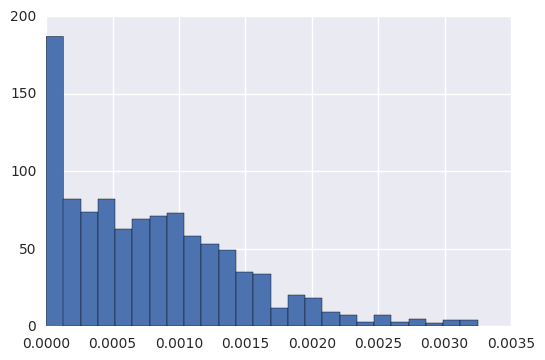

In [25]:
Series(bc).hist(bins = 25)

### Degree Centrality

In [26]:
dc = nx.degree_centrality(G)

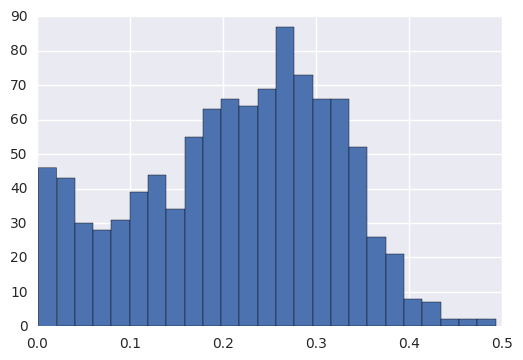

In [27]:
Series(dc).hist(bins = 25)

### Closeness Centrality

In [28]:
closenessc = nx.closeness.closeness_centrality(G)

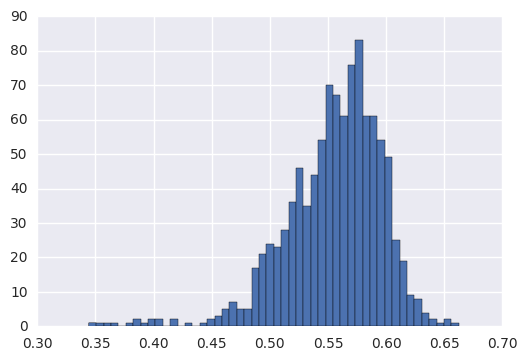

In [30]:
Series(closenessc).hist(bins=50)

# Plot Closeness and Age

In [31]:
import hatching as ht

In [32]:
start = "2016-07-26T12:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [33]:
def getAges(g, date_dt):
    aa = ht.get_all_bees_age(date_dt)
    df = DataFrame([int(x) for x in list(g.nodes())], columns=['id'])
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return df

In [34]:
def addCentrality(df, g):
    closenessC = nx.closeness_centrality(g)
    df['closeness'] = df.id.apply(lambda x: closenessC.get(str(x)))
    return df

In [35]:
df = getAges(G, start_dt)

In [36]:
df = addCentrality(df,G)

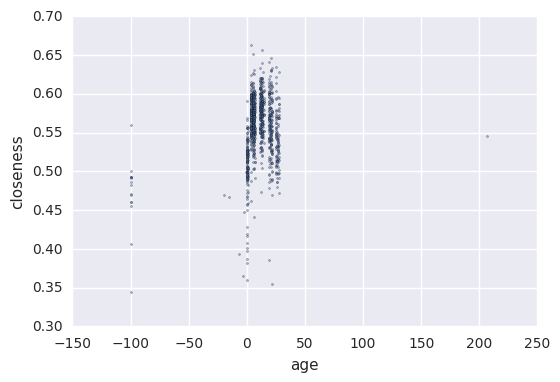

In [37]:
df.plot.scatter(x='age', y='closeness', s=2, alpha=0.5)

# Find the minimum between those two distributions

In [37]:
from sklearn.cluster import KMeans

In [38]:
l = list(df.closeness)

In [39]:
X = np.array(l)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6afbfc86a0>]], dtype=object)

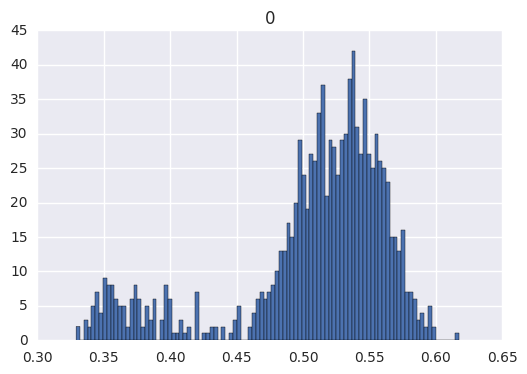

In [40]:
DataFrame(X).hist(bins=100)

In [41]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.reshape(-1, 1))

In [42]:
df['cluster'] = kmeans.labels_

In [43]:
df['cluster'] = df.cluster.apply(lambda x: x + 1)

In [44]:
kmeans.cluster_centers_

array([[ 0.50114075],
       [ 0.37425114],
       [ 0.5510001 ]])

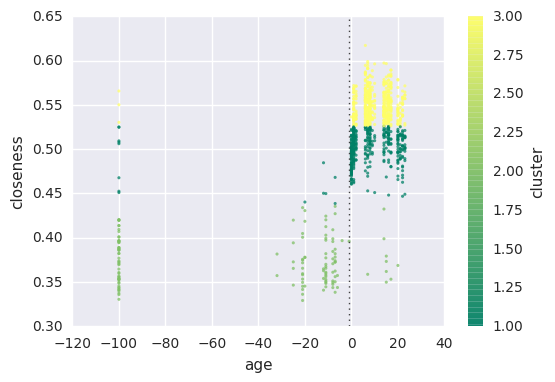

In [45]:
fig, ax = plt.subplots()
df.plot.scatter(x = 'age', y='closeness', s=5, c='cluster', edgecolors='none', cmap='summer', alpha=0.75, ax=ax)
plt.axvline(-1, color='0.25', linestyle='dotted', linewidth=1)
#plt.text(5,8,'~6%',rotation=0)

# Remove nodes with low closeness

In [46]:
np.argmin(kmeans.cluster_centers_)

1

In [47]:
removeIDS = list(df[df.cluster == np.argmin(kmeans.cluster_centers_)+1].id)

In [48]:
len(removeIDS)

140

In [49]:
for n in removeIDS:
    G.remove_node(str(n))

In [50]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 920
Number of edges: 88544
Average degree: 192.4870


Noch zusammenhängend?

In [51]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 1


Counter({920: 1})

In [52]:
def plotDegreeDist(G):
    degrees = G.degree().values()
    s = Series(list(degrees))
    s.hist(bins=50)

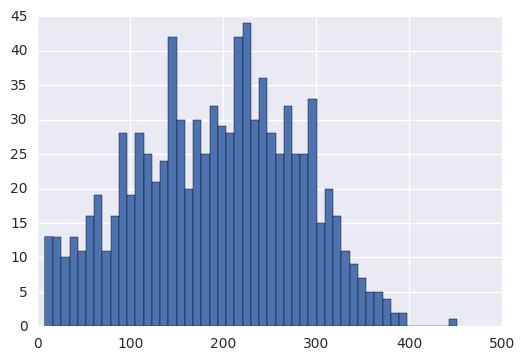

In [53]:
plotDegreeDist(G)

# Threshold Edges

In [54]:
lowedges = []
for a,b in list(G.edges()):
    data = G.get_edge_data(a,b)
    f = data.get('frequency')
    if f <= 2:
        lowedges.append((a,b))
    

In [55]:
len(lowedges)

66909

In [56]:
for e in lowedges:
    G.remove_edge(e[0],e[1])

In [57]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 21635\nAverage degree:  47.0326'

In [58]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 9


Counter({1: 8, 912: 1})

In [59]:
G = Gcc[0]

In [60]:
nx.write_graphml(G, 'ttt.graphml')

# Community Detection

In [61]:
def getCommunitiesFastGreedy(g, limit):

    fg = g.community_fastgreedy()
    vc = fg.as_clustering(fg.optimal_count)

    # keep communities with lots of members
    cl = [(e,s) for e,s in enumerate(vc.sizes()) if s > limit]

    print(cl)

    a,b = zip(*cl)

    a = list(a)
    b = list(b)

    membership = vc.membership
    ids = [[] for i in range(len(vc.sizes()))]

    for name, membership in zip(g.vs, membership):
        if membership in a:
            ids[membership].append(int(name['id']))

    return [i for i in ids if (len(i) > limit)]

In [62]:
g = ig.Graph.Read_GraphML('ttt.graphml')

In [63]:
c = getCommunitiesFastGreedy(g, 0)

[(0, 195), (1, 353), (2, 348), (3, 13), (4, 3)]


In [64]:
def getDFwithIDSts(ids, begin, end, conn):
    ids_str = ', '.join([str(x) for x in ids])
    sql = '''
        SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
        FROM DETECTIONS d
        INNER JOIN FRAME f
        ON d.FRAME_ID=f.FRAME_ID
        INNER JOIN FRAME_CONTAINER fc
        ON f.FC_ID=fc.FC_ID
        WHERE d.ID IN ({}) AND
        f.TIMESTAMP >= {} AND
        f.TIMESTAMP <= {};
    '''.format(ids_str, begin,end)
    return pd.read_sql(sql, conn)

In [65]:
db_path = "/mnt/data/data_2016_07_21_1day.db"
conn = sqlite3.connect(db_path)

In [66]:
# input: "2016-07-21T15:00:00Z"
# returns TS
def getTS(string):
    start_dt = datetime.datetime.strptime(string, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
    return start_dt.timestamp()

In [67]:
df0 = getDFwithIDSts(c[0], getTS('2016-07-21T06:00:00Z'), getTS('2016-07-21T20:00:00Z'), conn)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[  6.22000000e+02,   1.43000000e+02,   9.00000000e+01, ...,
          1.00000000e+00,   1.50000000e+01,   5.60000000e+01],
       [  6.20000000e+01,   7.80000000e+01,   6.30000000e+01, ...,
          1.24000000e+02,   3.40000000e+02,   2.03100000e+03],
       [  6.50000000e+01,   5.40000000e+01,   7.30000000e+01, ...,
          5.18000000e+02,   2.56000000e+02,   2.11000000e+02],
       ..., 
       [  1.96000000e+02,   2.15900000e+03,   2.86000000e+03, ...,
          1.35000000e+02,   2.20000000e+01,   0.00000000e+00],
       [  1.70000000e+02,   1.23700000e+03,   8.92000000e+02, ...,
          8.70000000e+01,   1.80000000e+01,   0.00000000e+00],
       [  6.80000000e+01,   7.14000000e+02,   1.03400000e+03, ...,
          1.17000000e+02,   2.70000000e+01,   0.00000000e+00]])

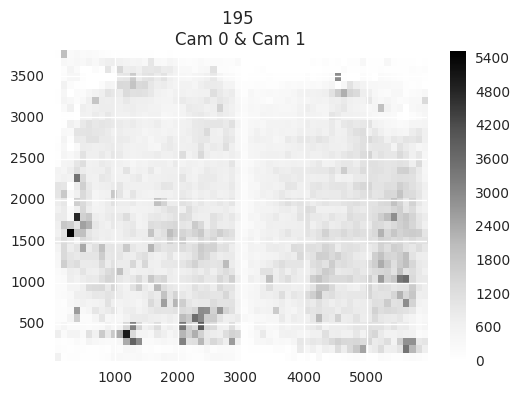

In [70]:
plotHeatmapXY(len(c[0]), df0, 0, 1)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[  21.,  155.,  718., ...,  275.,  350.,   47.],
       [  42.,  636.,  674., ...,  247.,  526.,  201.],
       [  81.,  125.,  676., ...,  258.,  519.,  153.],
       ..., 
       [  30.,   84.,  266., ...,  151.,  539.,  471.],
       [ 325.,  203.,  346., ...,  103.,  307.,  265.],
       [ 414.,  196.,  406., ...,  247.,  242.,  847.]])

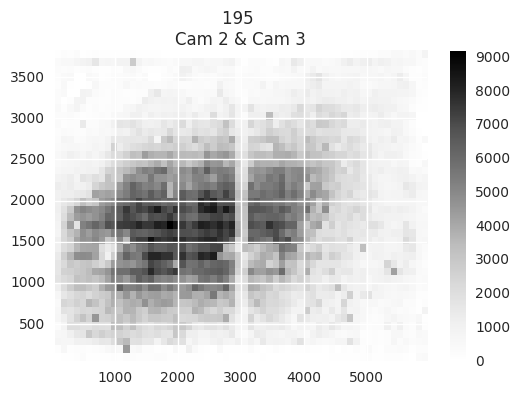

In [71]:
plotHeatmapXY(len(c[0]), df0, 2, 3)

In [72]:
df0 = getDFwithIDSts(c[1], getTS('2016-07-21T06:00:00Z'), getTS('2016-07-21T20:00:00Z'), conn)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[   25.,    14.,   119., ...,     9.,    47.,   144.],
       [   54.,    23.,   618., ...,   203.,   603.,  2610.],
       [   53.,    30.,   391., ...,   877.,   662.,   716.],
       ..., 
       [   67.,   394.,   801., ...,   135.,    41.,     0.],
       [   51.,   414.,   453., ...,    91.,    50.,     0.],
       [   58.,   614.,   408., ...,    73.,    72.,     0.]])

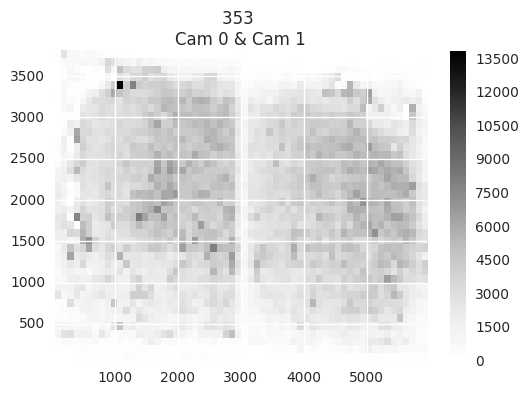

In [73]:
plotHeatmapXY(len(c[1]), df0, 0, 1)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[   24.,    75.,   523., ...,   309.,   395.,     3.],
       [   63.,    48.,   490., ...,   643.,   593.,    37.],
       [   68.,    55.,   476., ...,  1098.,  1040.,    81.],
       ..., 
       [    5.,    43.,   404., ...,   387.,   781.,  2024.],
       [   22.,    36.,   112., ...,   183.,   490.,   825.],
       [   12.,    10.,    88., ...,   107.,   163.,   202.]])

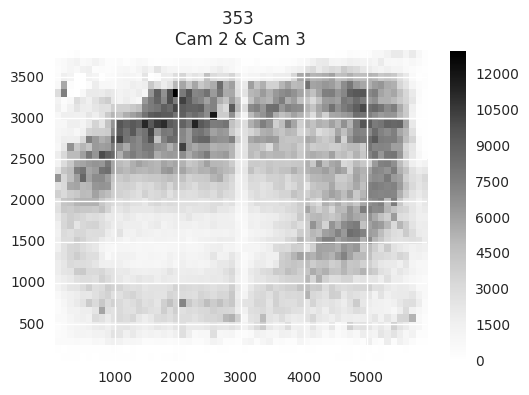

In [74]:
plotHeatmapXY(len(c[1]), df0, 2, 3)

In [75]:
df0 = getDFwithIDSts(c[2], getTS('2016-07-21T06:00:00Z'), getTS('2016-07-21T20:00:00Z'), conn)

In [76]:
def plotHeatmapXY(txt, df, camIDleft, camIDright):
    data_l = df[df.CAM_ID == camIDleft]
    data_r = df[df.CAM_ID == camIDright]
    data_r.XPOS = 3000 - data_r.XPOS
    data_r.YPOS = 4000 - data_r.YPOS
    data_r.XPOS = data_r.XPOS + 3000
    data = pd.concat([data_l,data_r])
    x = data.XPOS
    y = data.YPOS

    H, xedges, yedeges, im = plt.hist2d(x,y,bins=[60,40])
    plt.colorbar()
    plt.axes().set_title("{} \nCam {} & Cam {}".format(txt, str(camIDleft), str(camIDright)))
    
    return H

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[   17.,    19.,   580., ...,     0.,     0.,     0.],
       [   18.,    23.,   694., ...,   102.,    59.,    19.],
       [   48.,    76.,   438., ...,   710.,   325.,    50.],
       ..., 
       [  105.,   663.,   949., ...,    54.,    13.,     0.],
       [  115.,   964.,   763., ...,    75.,    13.,     0.],
       [  243.,  1853.,  1129., ...,    38.,    26.,     0.]])

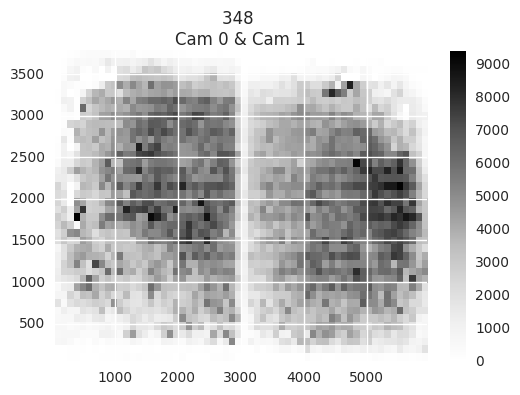

In [77]:
plotHeatmapXY(len(c[2]), df0, 0, 1)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[  11.,   77.,  503., ...,  406.,  269.,   21.],
       [  34.,   80.,  607., ...,  737.,  493.,  218.],
       [ 124.,  123.,  747., ...,  901.,  892.,  283.],
       ..., 
       [ 103.,   43.,  266., ...,  104.,   97.,   41.],
       [ 258.,   41.,  213., ...,   26.,   36.,   21.],
       [ 109.,  113.,  189., ...,   31.,   36.,   38.]])

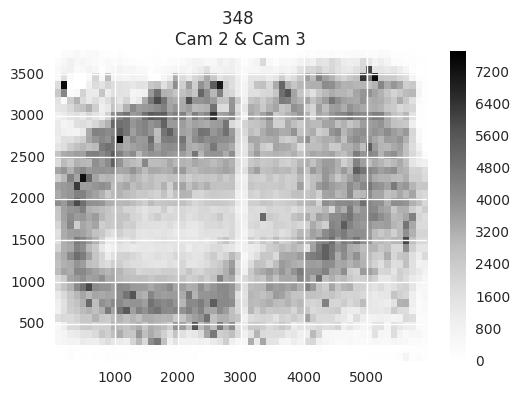

In [78]:
plotHeatmapXY(len(c[2]), df0, 2, 3)

In [58]:
DataFrame(np.array(list("AACDEBGKJGASAVBBNWTSVANBM")).reshape(5,5), columns=list("ABCDF")).groupby(by="A").size().shape

(3,)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'K', 'J', 'G', 'H', 'S', 'A',
       'V', 'B', 'B', 'N', 'W', 'T', 'S', 'V', 'A', 'N', 'B', 'M'], 
      dtype='<U1')

In [62]:
Series().empty

True